In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import binned_statistic_2d

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    hour = np.array(dic['hour'])[mask]
    year = np.array(dic['year'])[mask]
#    date = np.array(dic['date'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
  #  tgrad = np.array(dic['tgrad'])[mask]
  #  tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    #pall = np.array(dic['p'])[mask]
    
    
    
#     p = units.Quantity(650, 'hPa')
#     t = units.Quantity(tup, 'K')
    
#     thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
#     #thetae_up = u_met.theta_e(650, tup-273.15, qup)


#     thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

#     p = units.Quantity(925, 'hPa')
#     t = units.Quantity(tlow, 'K')
#     q = units.Quantity(qq, 'kg/kg')
#     thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
#     dew = calc.dewpoint_from_specific_humidity(q, t, p)
#     thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
#     thetae = thetae_down - thetaes_up
#     thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
#     if tgrad.ndim == 2:
#         tgrad = tlow
#     if tbox.ndim == 2:
#         tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp+3,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,    
        'hour' : hour,
        'year' : year,
 #       'date' : date,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
#         'theta_e' : thetae,
#         'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
      #  'tgrad' : tgrad.squeeze(),
       # 'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
     #   'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
  #  tgrad = np.array(dic['tgrad'])
   # tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    hour = np.array(dic['hour'])
    #pall = np.array(dic['p'])

#     p = units.Quantity(650, 'hPa')
#     t = units.Quantity(tup+273.15, 'K')
    
#     thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

#     thetaes_up = np.array(thetaes_up)

#     p = units.Quantity(925, 'hPa')
#     t = units.Quantity(tsrfc+273.15, 'K')
#     q = units.Quantity(qq/1000, 'kg/kg')
#     thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
#     dew = calc.dewpoint_from_specific_humidity(q, t, p)
#     thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
#     thetaes = thetaes_down-thetaes_up  
#     thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
#     try:
#         thetamax = np.array(dic['thetamax'])
#         thetamean = np.array(dic['thetamean'])   
#     except:
#         pass
   # ipdb.set_trace()
    obs_pcp = {
        'prcp' : pp+2,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
       # 'tgrad' : tgrad,
        #'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'hour' : hour,
#         'theta_es' : thetaes,
      #  'pall' : pall
    } 

#     try:
    #obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [6]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

In [7]:
obs_gpmf.head()

,prcp,q925,q650,t925,shear,month,hour,year,area,tmin,rh,tcwv,lat,lon
0,7.546894,15.324332,6.423853,24.874475,14.258469,7,17,2004,5975,-77.805445,72.686592,47.977135,16.581171,0.312186
1,46.385965,14.628493,5.576330,22.627802,17.359905,9,19,2004,83175,-75.000000,78.363197,47.305939,11.289606,-13.870493
2,23.520223,14.666178,6.573158,19.529047,4.076474,9,18,2004,60150,-76.466973,95.035973,53.804394,6.743863,-7.025343
3,11.098122,15.512402,5.839916,23.767664,5.012726,8,17,2004,7275,-73.380482,77.722290,50.499004,8.643763,10.914400
4,23.549192,14.712868,4.529143,22.579614,11.788300,9,18,2004,6725,-76.211019,79.081085,42.870922,7.967304,-9.138874


In [8]:
obs_gpmf.to_csv('/home/ck/DIR/cornkle/data/LMCS/CLOVER_mcs_tables/obs_bulk_-50_5000km2_GPM_passiveMW_5-18N_17W13E_ERA0.7_15kprecip_hourly.csv')

In [9]:
histf

,prcp,q925,t925,tcwv,shear,month,area,tmin,tmean,lat,lon,hour
0,24.150555,15.790208,23.65,45.754488,3.997396,3,15778.40,-71.069966,-61.582216,5.687252,-7.247009,16
1,20.235777,14.702553,23.56,41.902553,6.571809,3,12622.72,-71.429903,-60.773651,6.112501,-8.360748,16
2,5.514763,14.866596,23.62,45.671885,5.864362,3,7608.48,-63.254817,-57.528173,6.011251,-5.667496,16
3,2.007660,15.755714,26.81,43.270834,6.642857,3,10551.20,-63.494701,-55.189358,6.720003,5.571259,16
4,22.825022,14.899667,23.16,49.017225,6.741667,3,4781.92,-70.673788,-59.982723,6.841503,-10.223755,16
...,...,...,...,...,...,...,...,...,...,...,...,...
12924,5.517820,14.465111,22.55,45.278567,1.436111,11,7066.40,-70.809773,-58.857489,5.505003,-6.416763,19
12925,15.603901,15.099333,22.30,44.314805,-0.019444,11,7918.24,-75.309984,-60.096726,5.687252,-8.340500,19
12926,29.443941,14.958333,22.29,41.924609,0.464286,11,6717.92,-75.424867,-65.572313,5.403751,-7.631744,16
12927,9.273108,15.175918,22.29,44.198455,1.556122,11,9350.88,-71.630128,-62.369820,5.525251,-7.530502,17


In [10]:
histf.to_csv('/home/ck/DIR/cornkle/data/LMCS/CLOVER_mcs_tables/CP4hist_bulk_-50_5000km2_5-25N_12W15E_15kprecip_hourly.csv')

In [11]:
futf.to_csv('/home/ck/DIR/cornkle/data/LMCS/CLOVER_mcs_tables/CP4fut_bulk_-50_5000km2_5-25N_12W15E_15kprecip_hourly.csv')

In [12]:
obs_gpmf = obs_gpmf[obs_gpmf['area']<300000]

In [13]:
np.percentile(histf['tcwv'],0.5)  # 99.5 percentile

25.460361663990856

29650.89872595959
32104.634461737405
34312.317419003964
37293.280467445744
39329.32471343928
29650.89872595959
32104.634461737405
34312.317419003964
37293.280467445744
39329.32471343928


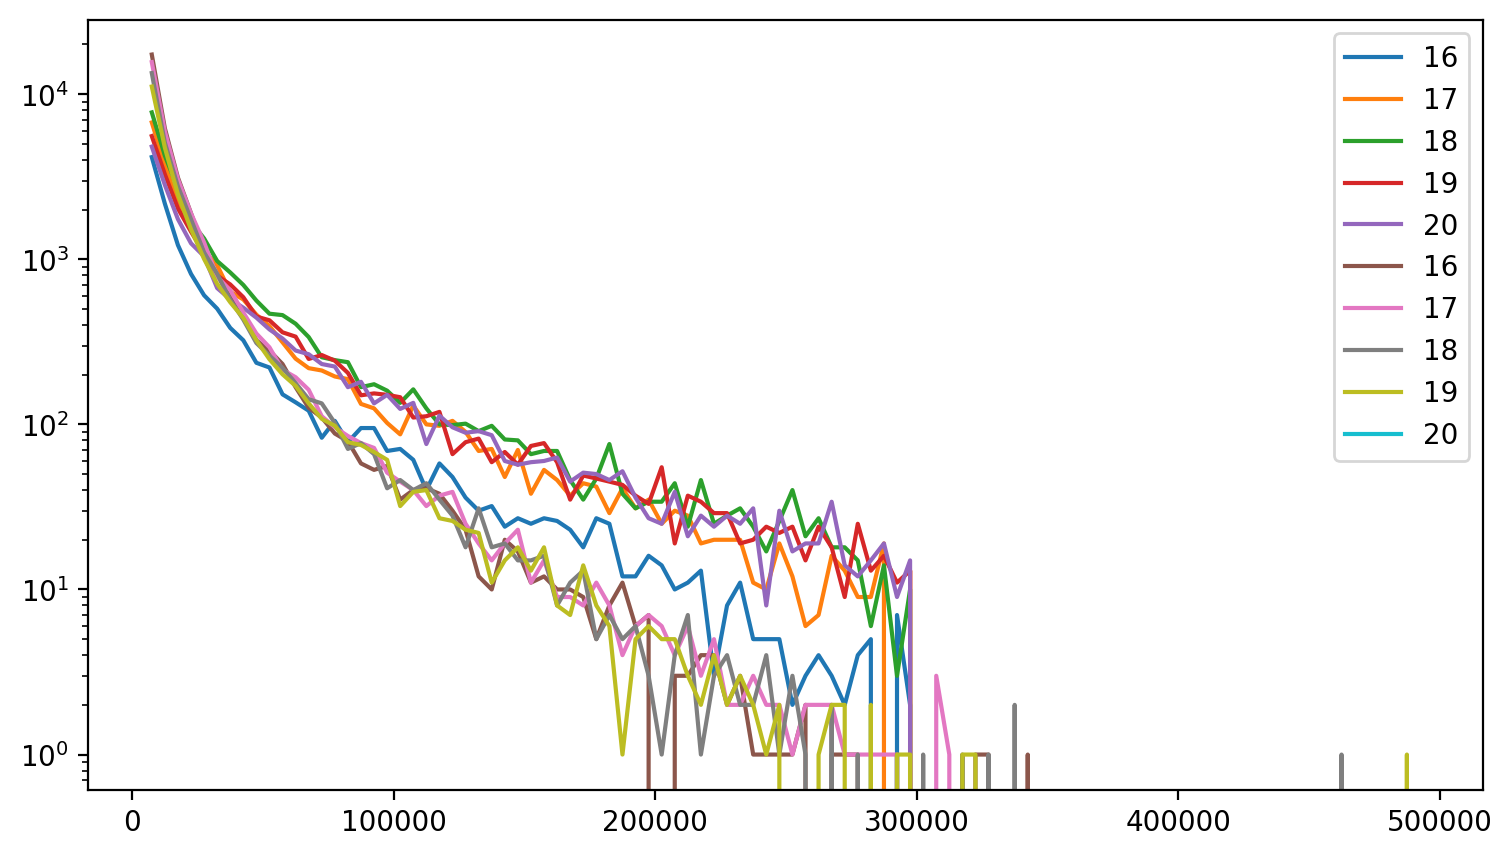

In [41]:
from utils import u_statistics as u_stats
f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)
for h in ([16, 17,18,19,20]):
    hist, count, binz = u_stats.histo_frequency(obs_gpmf[obs_gpmf['hour']==h]['area'], bins=np.arange(5000,500000,5000))
    #ax.hist(obs_gpmf[obs_gpmf['hour']==h]['area'], bins=np.arange(5000,500000,5000), label=str(h))
    binmid = binz[1::]-(binz[1::]-binz[0:-1])/2
   # ipdb.set_trace()
    plt.plot(binmid, count, label=str(h))
    ax.set_yscale('log')
    print(np.mean(obs_gpmf[obs_gpmf['hour']==h]['area']))
    
plt.legend()

29650.89872595959
32104.634461737405
34312.317419003964
37293.280467445744
39329.32471343928


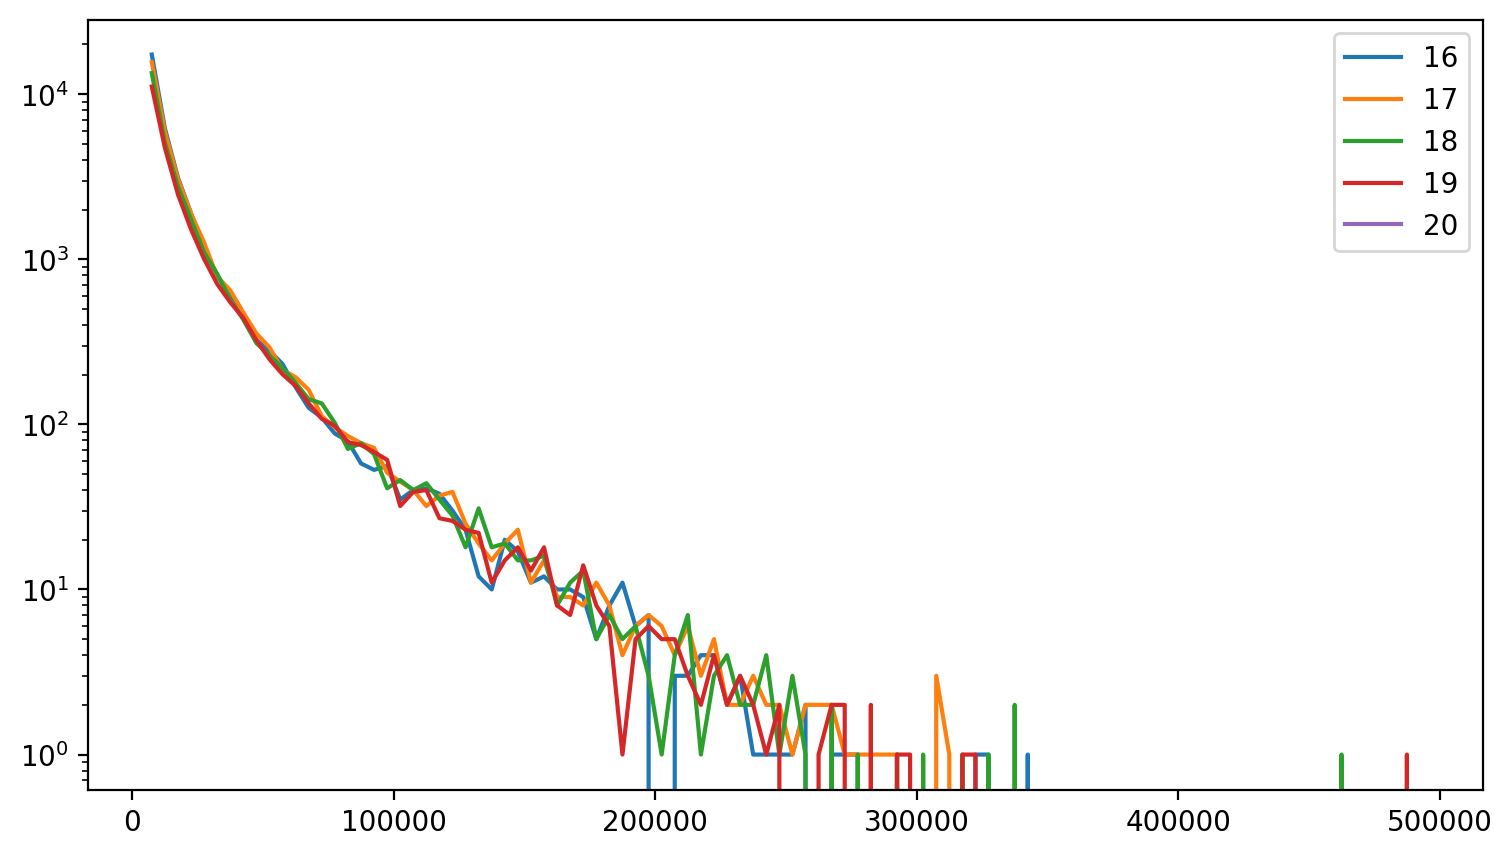

In [39]:
from utils import u_statistics as u_stats
f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)
for h in ([16, 17,18,19,20]):
    hist, count, binz = u_stats.histo_frequency(histf[histf['hour']==h]['area'], bins=np.arange(5000,500000,5000))
    #ax.hist(obs_gpmf[obs_gpmf['hour']==h]['area'], bins=np.arange(5000,500000,5000), label=str(h))
    binmid = binz[1::]-(binz[1::]-binz[0:-1])/2
   # ipdb.set_trace()
    plt.plot(binmid, count, label=str(h))
    ax.set_yscale('log')
    print(np.mean(obs_gpmf[obs_gpmf['hour']==h]['area']))
plt.legend()

In [42]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
5.160526954051596
12.107882421128927
-16.97683096799293


In [43]:
print(np.max(histf.lat))
print(np.min(histf.lat))
print(np.max(histf.lon))
print(np.min(histf.lon))

24.762752532958984
5.181001663208008
14.764739990234375
-11.783004760742188


In [54]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-10,12,11,18]#[-10,15,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-4.5,2,11,13.5]  

nb = 23
if ttag == 'hourly':
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(3,24,nb), np.linspace(-10,10,nb), np.linspace(29,55,nb)], #TCW np.linspace(25,57,nb) #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
              'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
              'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
              'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
             }
else:
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(7,18,nb), np.linspace(-10,10,nb), np.linspace(28,51,nb)], # 28,51 #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
         }


domain = region[tag][0]
tname = region[tag][1]


m1 = 5#3
m2 =10#11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [55]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 11.013002395629883 17.99925422668457 -9.980758666992188 11.990509033203125
OBS_gpm 11.000092058192642 17.72173831393142 -9.996829961744087 11.9997069672409


In [56]:
len(obs_gpm)

38290

In [57]:
np.mean(hist.prcp)


19.686368254174287

In [58]:
np.percentile(hist.prcp,95)

40.66572374704551

In [59]:
hist.prcp

2066     18.438323
2069     21.878401
2080     23.399325
2090     16.411038
2108     21.865938
           ...    
12307    24.013017
12320    14.033019
12330     4.135596
12346    10.298958
12422     7.672075
Name: prcp, Length: 35581, dtype: float64

Text(0.5, 1.0, '-0.59')

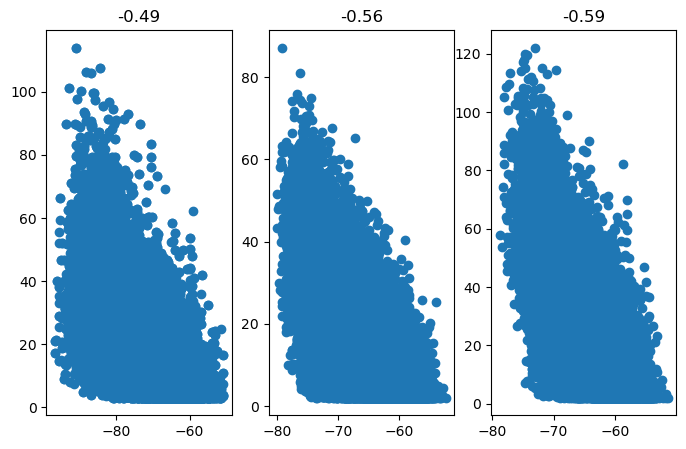

In [60]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5, 1.0, '-0.54')

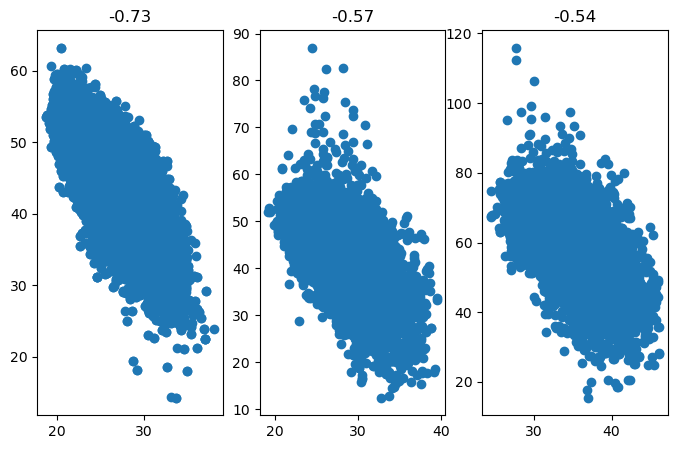

In [61]:

cp4s = [obs_gpm.t925, obs_gpm.tcwv] # gpm
cp25s = [hist.t925, hist.tcwv] #cp4
futur = [fut.t925, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

Text(0.5, 1.0, '0.04')

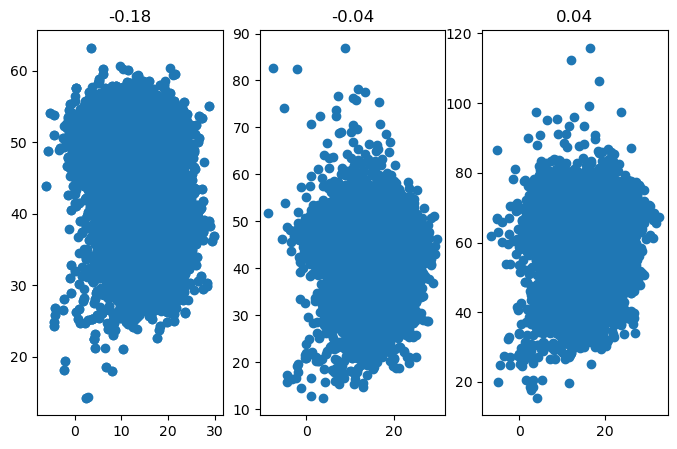

In [62]:

cp4s = [obs_gpm.shear, obs_gpm.tcwv] # gpm
cp25s = [hist.shear, hist.tcwv] #cp4
futur = [fut.shear, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [63]:
oposi = (obs_gpm.q925>=8.) & (obs_gpm.shear>0) &  (obs_gpm.prcp>=10) & (obs_gpm.area>=15000) & (obs_gpm.tmin<=-55) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #0.1
cposi = (hist.q925>=8.) & (hist.shear>0) &  (hist.prcp>=10) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-55)
fposi = (fut.q925>=8.) & (fut.shear>0) &  (fut.prcp>=10) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-55)

In [64]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/tmp/ipykernel_18690/1230285955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp4.area = cp4.area.values


In [65]:
np.percentile(obs.tcwv,99)

54.548194885253906

In [66]:
cp4.area.min()

5014.240000000001

In [67]:
obs.area.min()

15000

In [68]:
len(obs)

19505

In [69]:
len(cp4)

27091

In [70]:
len(cp4f)

22559

In [71]:
obs

,prcp,q925,q650,t925,shear,month,hour,year,area,tmin,rh,tcwv,lat,lon
10,16.328457,14.194973,5.219087,31.544763,15.656520,5,19,2004,39575,-77.117395,45.148972,37.642086,13.216275,1.133634
11,21.698131,12.471479,2.995297,31.943262,17.794252,8,17,2004,43050,-78.000000,38.850033,28.914478,16.827724,6.596098
15,24.865272,15.573963,3.640368,25.510522,14.365740,9,18,2004,156075,-86.946189,70.473007,37.970367,11.418261,7.850773
39,23.371461,15.178798,4.645086,24.740656,17.204939,6,21,2004,38300,-79.552083,72.080963,43.602722,11.566451,-4.275126
40,18.525872,13.484879,5.586335,28.888635,19.632133,6,18,2004,26675,-74.675883,50.118320,40.687710,15.341460,6.037754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273,19.515169,16.869690,4.613310,21.886835,15.086042,7,16,2014,93725,-80.739648,94.582001,48.254196,12.271467,-8.305027
4278,34.060492,14.406480,7.101244,22.273004,11.730873,7,18,2014,70050,-78.000000,78.170990,50.405071,11.160577,-4.642597
4279,27.226537,14.468893,6.925683,28.642419,14.023110,9,18,2014,235525,-88.275562,55.092400,45.683926,12.099752,0.386603
4285,40.668690,15.561934,6.329843,26.299036,16.193760,7,21,2014,73750,-81.801170,67.127678,45.278271,11.449250,-2.363456


/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'MCS number')

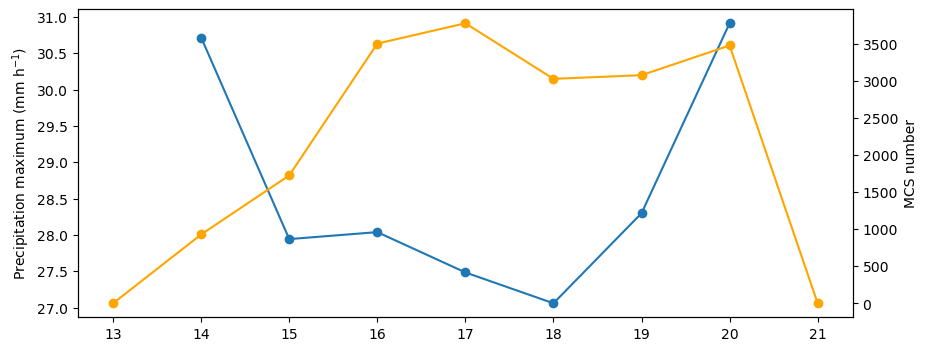

In [72]:
from endgame import hist2d
outdic = hist2d.var2_binning_mean(obs['hour'].values, obs['prcp'].values, np.array([13.5,14.5,15.5,16.5,17.5,18.5,19.5,20.5,21.5,22.5]))
#from scipy.ndimage import gaussian_filter1d
f= plt.figure(figsize=(10,4), dpi=100)
ax = f.add_subplot(111)
ax.plot(outdic['xbins']-1, outdic['y'], marker='o')
ax.set_ylabel('Precipitation maximum (mm h$^{-1}$)')
ax1 = ax.twinx()
ax1.plot(outdic['xbins']-1, outdic['ycount'], marker='o', color='orange')
ax1.set_ylabel('MCS number')

In [73]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [74]:
len(pro)

NameError: name 'pro' is not defined

PearsonRResult(statistic=-0.19105825484863515, pvalue=1.0812259333467604e-155)


Text(0.5, 0, 'MCS index')

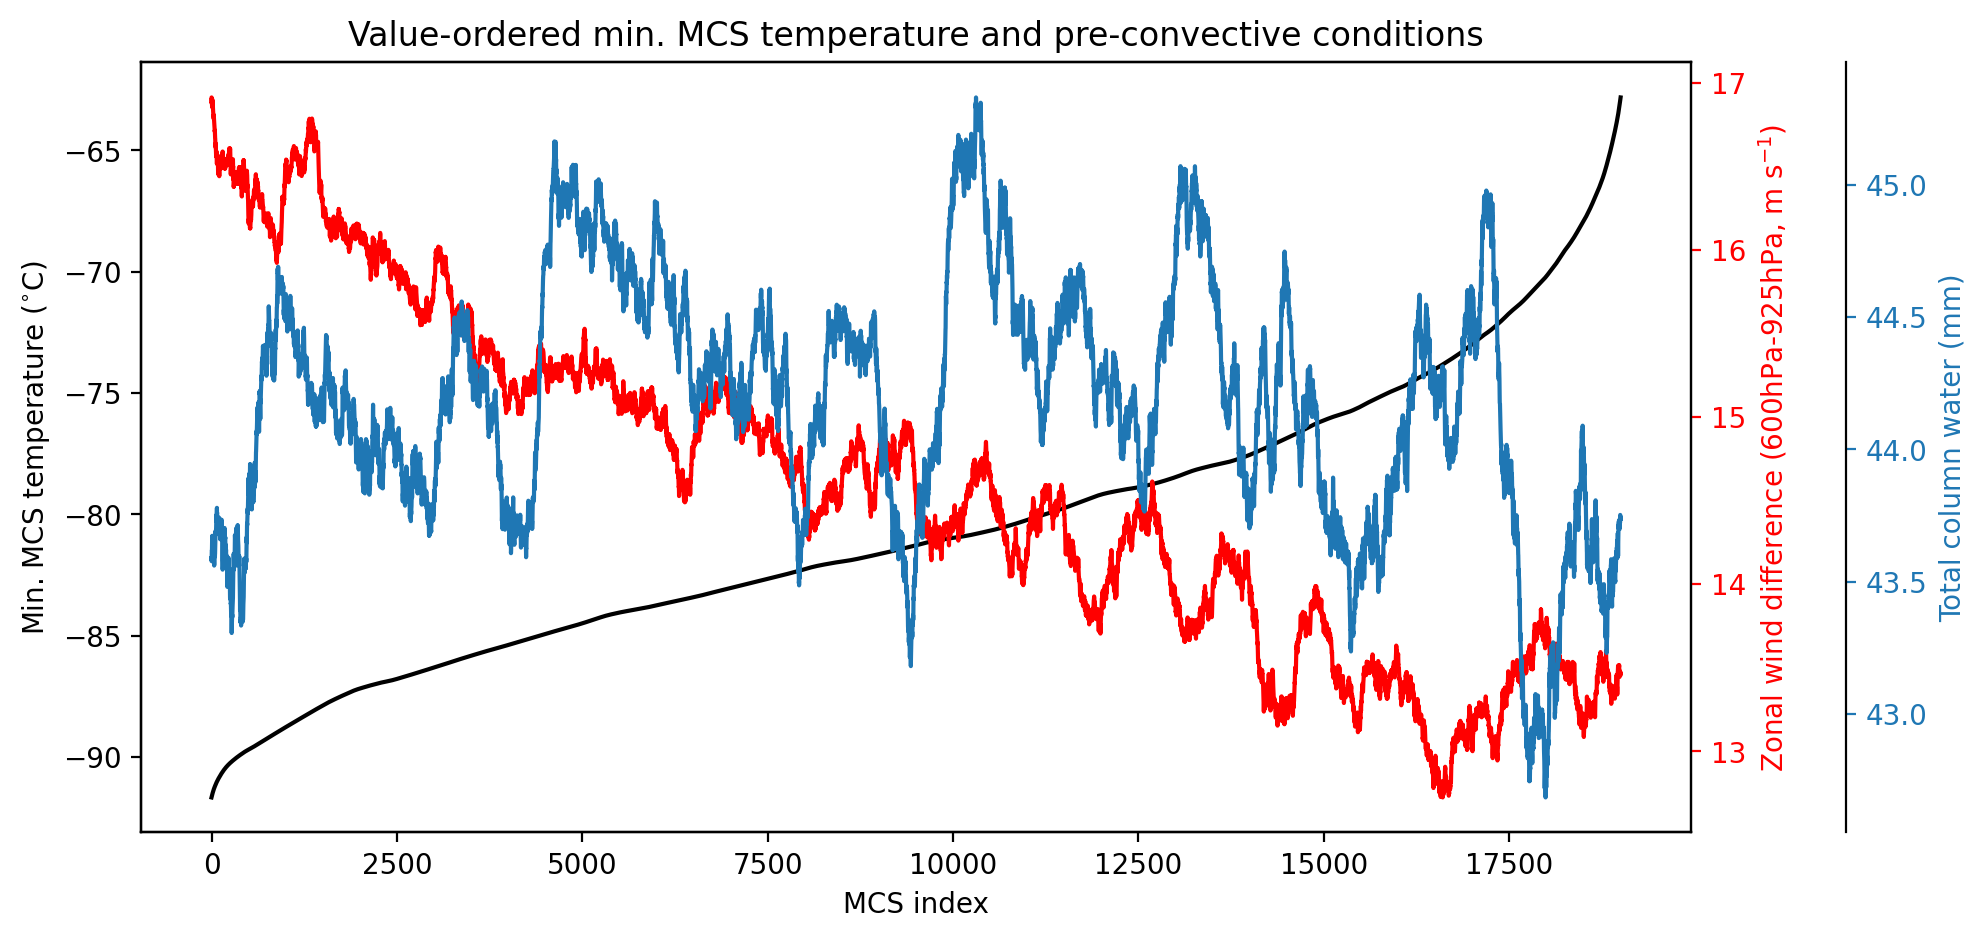

In [75]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['tmin'])

minus = -20000
pro = obsord['tmin'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['q650'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 500


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Min. MCS temperature ($^{\circ}$C)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered min. MCS temperature and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_15000.jpg')

PearsonRResult(statistic=-0.19299289722218074, pvalue=1.5684259978873412e-160)


Text(0.5, 0, 'MCS index')

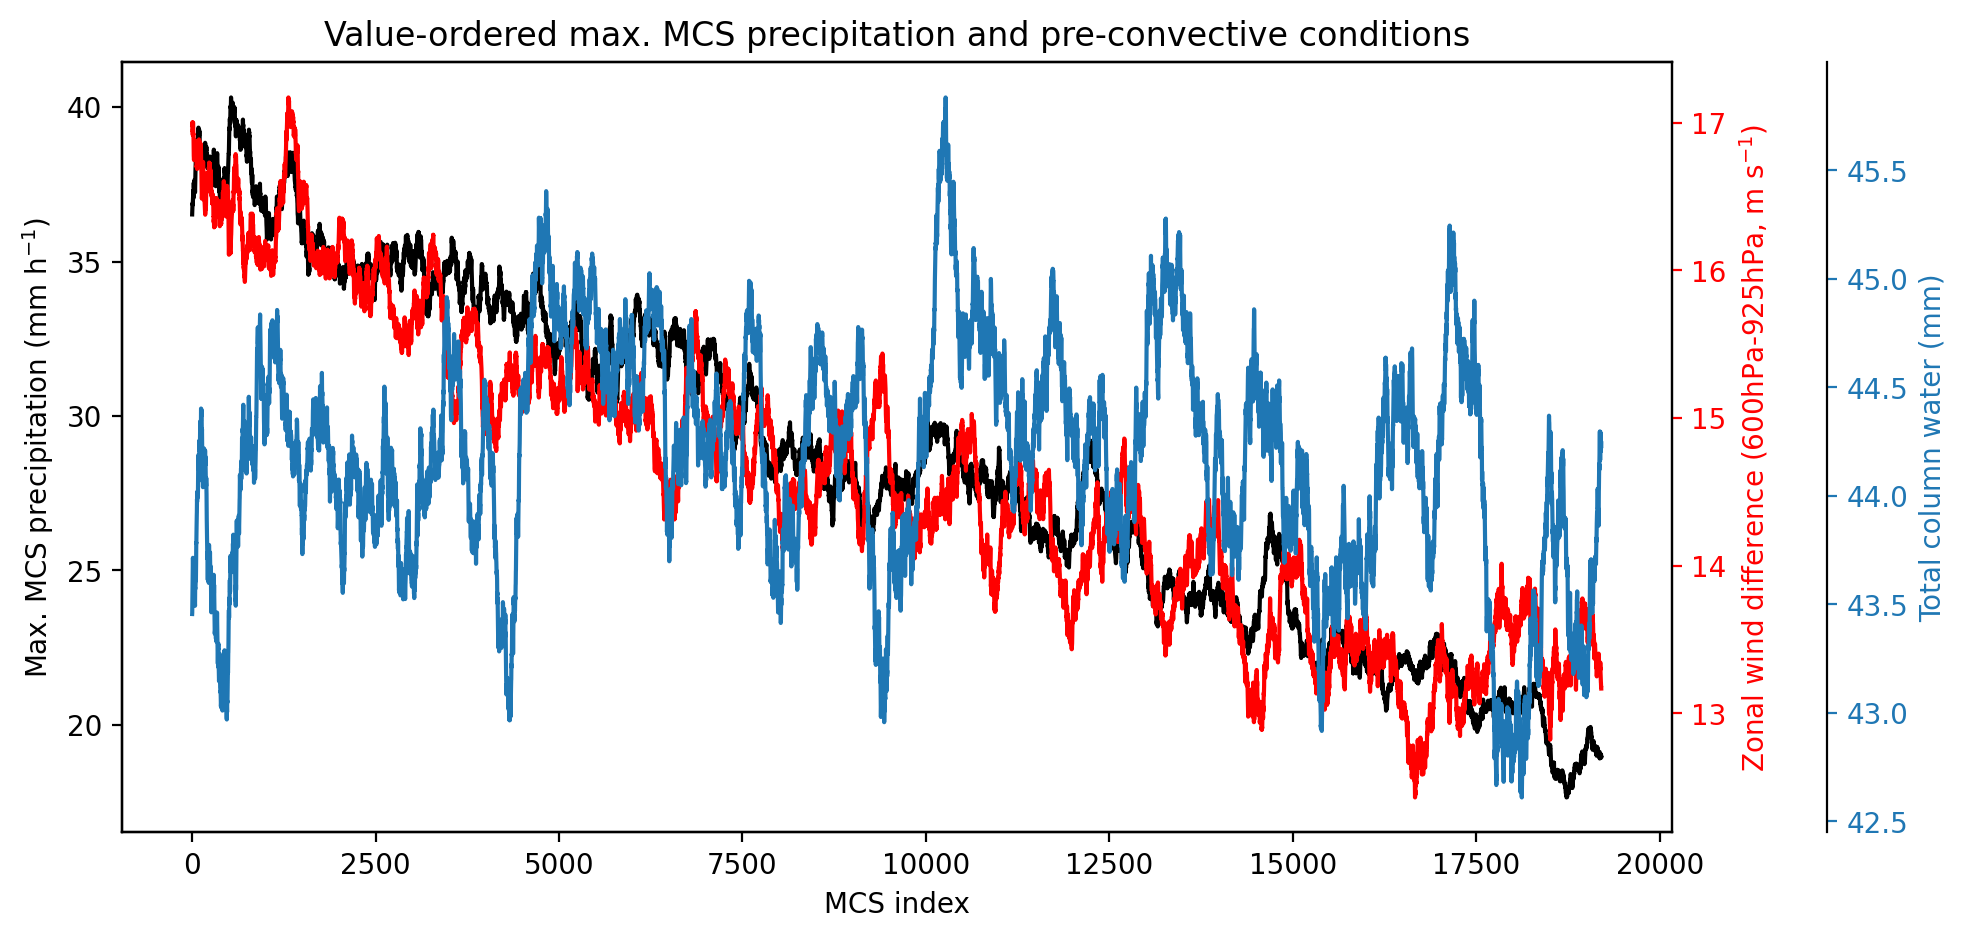

In [84]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['tmin']) # tmin

minus = -20000
pro = obsord['prcp'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['q650'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 300  # 500


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_withP_15000.jpg')

(-0.20842950913302125, 4.268141716835625e-165)


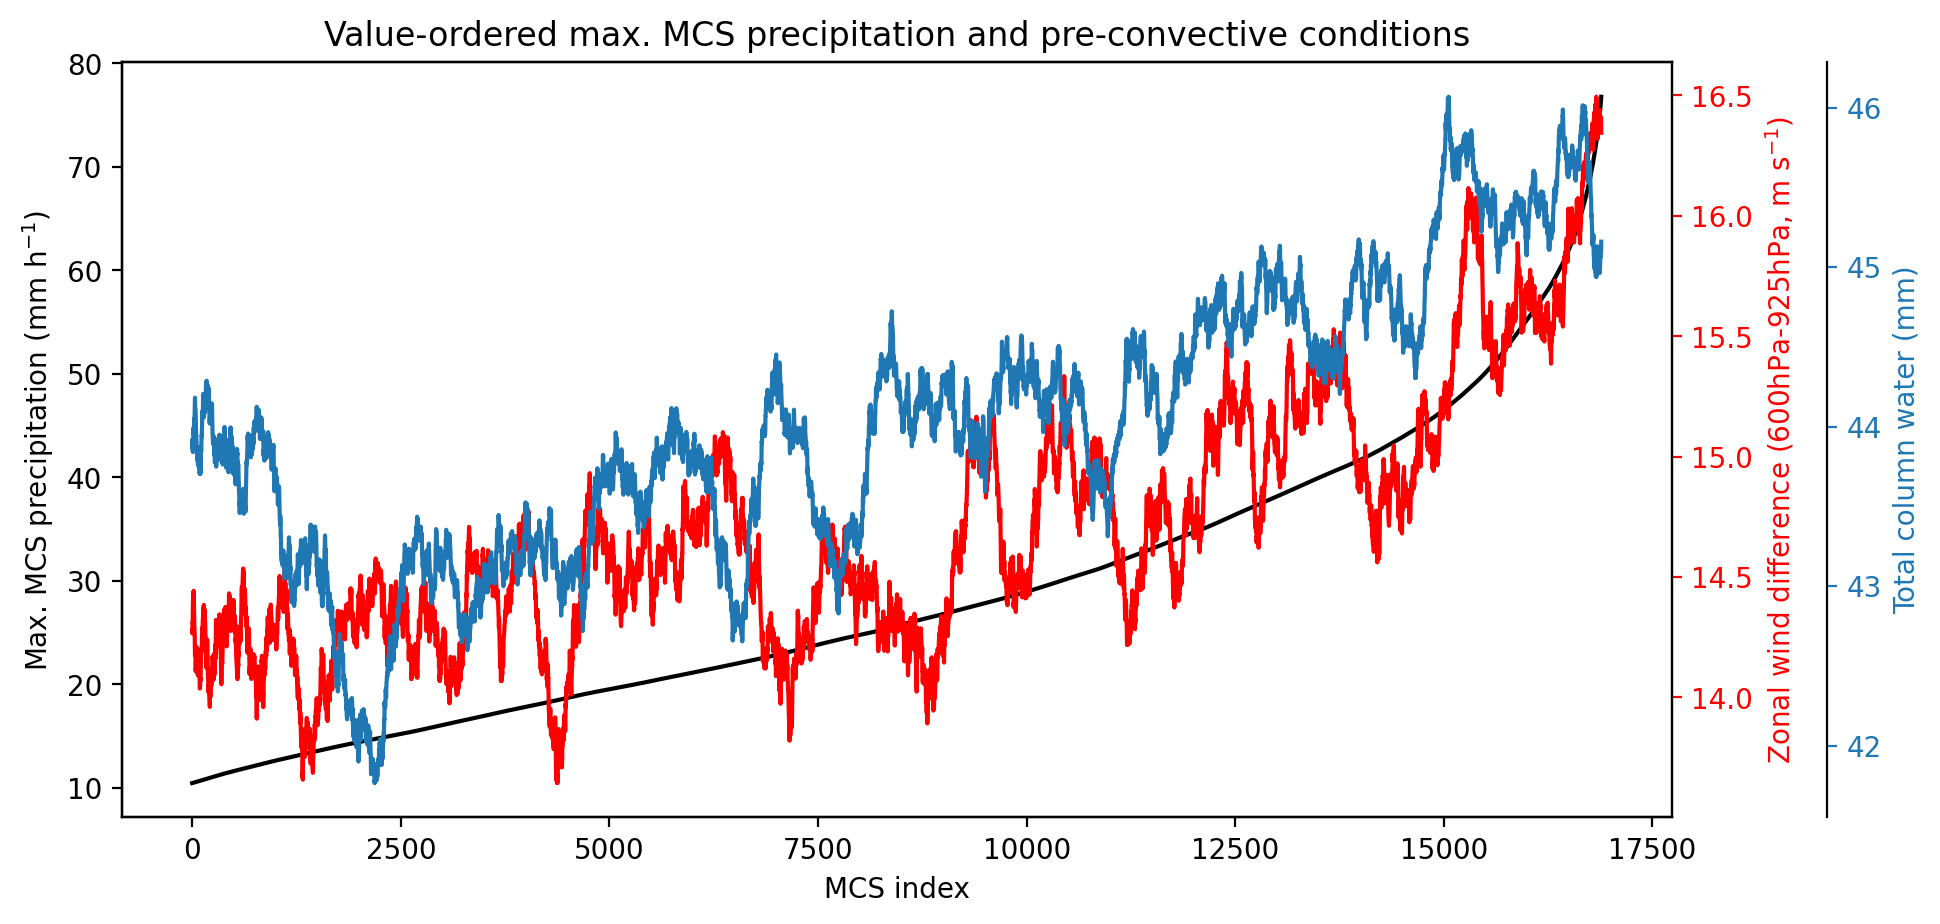

In [268]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['prcp'])

minus = -20000
pro = obsord['prcp'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['q650'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 400


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcwv')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/maxP_ordered_15000.jpg')

(0.11392202966361681, 0.2716553609878901)


Text(0.5, 0, 'MCS index')

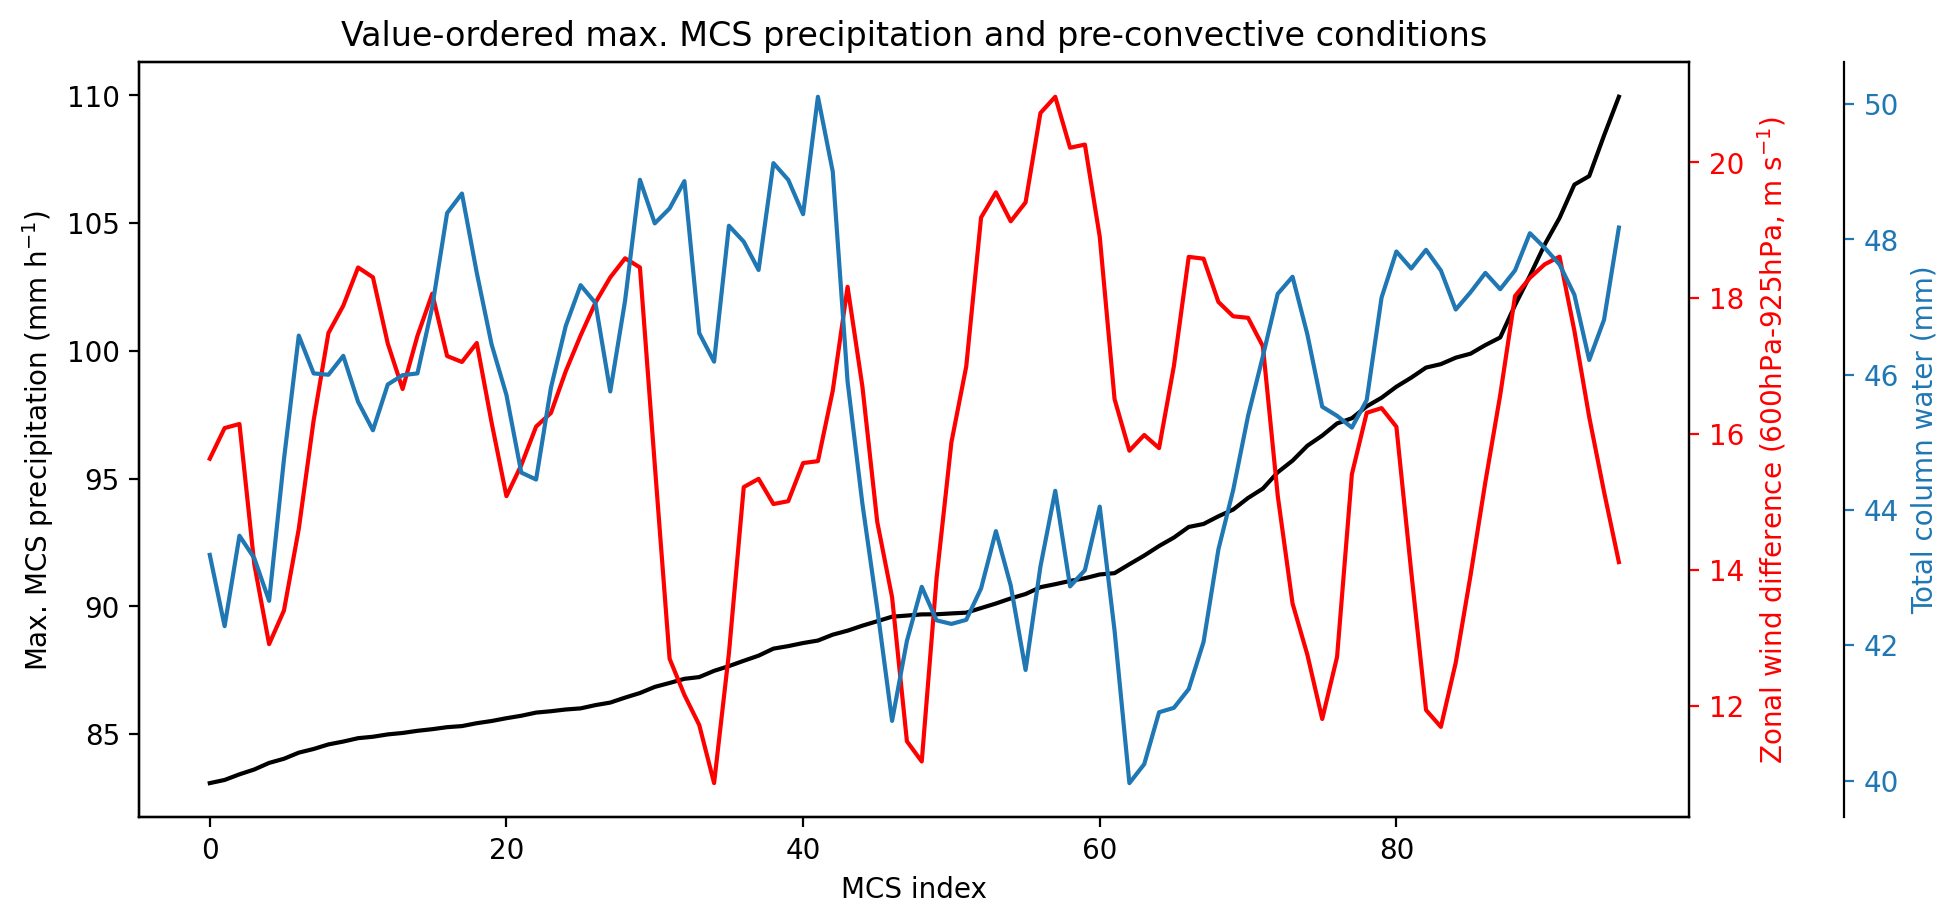

In [247]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['prcp'])

minus = -100
pro = obsord['prcp'].values[inds][minus::]
sho = obsord['shear'].values[inds][minus::]
tco = obsord['tcwv'].values[inds][minus::]
qco = obsord['q925'].values[inds][minus::]
temp = obsord['t925'].values[inds][minus::]
qupco = obsord['q650'].values[inds][minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 5


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/maxP_ordered.jpg')

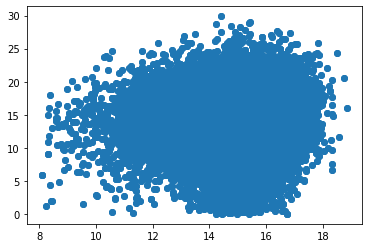

In [108]:
plt.scatter(obs.q925, obs.shear)

In [413]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [414]:
# sbin = np.linspace(0,26.8,25)
# tbin = np.linspace(27,57,25)

sbin = np.linspace(0,26.7,28) #28
#tbin = np.linspace(27,57,28)

q1 = 0.8 #0.8
q2 = 99.5#99.5
#sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),28) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),26)

testbins = [sbin,tbin]
func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>40)
ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func1, bins=testbins)
count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func2, bins=testbins)
thresh = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func3, bins=testbins)

In [415]:
# # sbin = np.linspace(0,26.8,25)
# # tbin = np.linspace(27,57,25)

# sbin = np.linspace(0,26.7,28) #28
# #tbin = np.linspace(27,57,28)

# q1 = 0.2 #0.8
# q2 = 99.8#99.5
# sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),28) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
# tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),28)

# testbins = [sbin,tbin]
# func1 = lambda y: np.percentile(y, 95)
# func2 = lambda y: np.sum(np.isfinite(y))
# ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func1, bins=testbins)
# count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func2, bins=testbins)

In [244]:
ret4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=func1, bins=testbins)
count4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=func2, bins=testbins)

In [245]:
def run_small(data, count, testbins, axis=0):
    
    dd = gauss(data.statistic.T, 0.6)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    mean = np.nanmean(dd,axis=axis)
    val = np.nansum(np.isfinite(dd),axis=axis)
    
    mean[val<4] = np.nan
    
    perc = np.nanpercentile(dd, [10,90], axis=axis)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight
    
    sbin = testbins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    fillmean = mean.copy()
    fillmean[np.isnan(fillmean)]=0

    val[np.isnan(fillmean)]=0
    wls_model = weighted_regress(bins[0:-3], fillmean[0:-3], val[0:-3])

    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    
    #ipdb.set_trace()
    
    print(wls_model.summary())
    
    
   # ipdb.set_trace()
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pmean' :mean,
        'p90' : perc[0],
        'p10' : perc[1],
        'bins' : bins,
        'std_est' : wls_model.bse[0],
        'valid' : val,
        'model' : wls_model
    }
    
    return odic

In [246]:
def run_small_2d(data, count, testbins):
    
    dd = gauss(data.statistic.T, 0.4)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    
    mean_x = np.nanmean(dd,axis=0)
    val_x = np.nansum(np.isfinite(dd),axis=0)
    mean_x[val_x<4] = np.nan
    perc_x = np.nanpercentile(dd, [10,90], axis=0)
    
    mean_y = np.nanmean(dd,axis=1)
    val_y = np.nansum(np.isfinite(dd),axis=1)
    mean_y[val_y<4] = np.nan
    perc_y = np.nanpercentile(dd, [10,90], axis=1)
    
    
    sbin = testbins[0]
    tbin = testbins[1]
    ssbins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    ttbins = np.round(tbin[0:-1]+((tbin[1::]-tbin[0:-1])/2),2)
    
    X,Y = np.meshgrid(ssbins, ttbins)

    # First we need to flatten the data: it's 2D layout is not relevent.
    counts = count.statistic.T
    Z = dd.flatten()
    X = X.flatten()
    Y = Y.flatten()
    inval = counts.flatten()
    
   
    ################################################################
    # For 3d plots. This import is necessary to have 3D plotting below
    from mpl_toolkits.mplot3d import Axes3D
    import pandas
    # For statistics. Requires statsmodels 5.0 or more
    from statsmodels.formula.api import wls
    # Analysis of Variance (ANOVA) on linear models
    from statsmodels.stats.anova import anova_lm
    # Convert the data into a Pandas DataFrame to use the formulas framework
    # in statsmodels


    data = pandas.DataFrame({'x': X, 'y': Y, 'z': Z})
    weight = inval / np.sum(inval)
    # Fit the model
    model = wls("z ~ x + y", data, weights=weight, missing='drop').fit()

    # Print the summary
    print(model.summary())

    print("\nRetrieving manually the parameter estimates:")
    print(model._results.params)
    # should be array([-4.99754526,  3.00250049, -0.50514907])

    # Peform analysis of variance on fitted linear model
    anova_results = anova_lm(model)

    print('\nANOVA results')
    print(anova_results)

    plt.show()
    ################################################################
    
    odic = {
        'model' : model,
        'pmean_x' :mean_x,
        'pmean_y' :mean_y,
        'p90_x' : perc_x[0],
        'p10_x' : perc_x[1],
        'p90_y' : perc_y[0],
        'p10_y' : perc_y[1],
        'bins_x' : ssbins,
        'bins_y' : ttbins
    }
    
    return odic

In [247]:
tdicobs = run_small(ret, count, testbins,axis=1)
sdicobs = run_small(ret, count, testbins,axis=0)
tdic4 = run_small(ret4, count4, testbins,axis=1)
sdic4 = run_small(ret4, count4, testbins,axis=0)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.651
Model:                            WLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     37.34
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           5.68e-06
Time:                        15:43:24   Log-Likelihood:                -58.238
No. Observations:                  22   AIC:                             120.5
Df Residuals:                      20   BIC:                             122.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.6967      5.065      3.494      0.0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:764: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np

In [249]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [250]:
tdicobs.r_value

AttributeError: 'dict' object has no attribute 'r_value'

In [251]:
tb = testbins[1][0:-1] + (testbins[1][1::] - testbins[1][0:-1])/2
sb = testbins[0][0:-1] + (testbins[0][1::] - testbins[0][0:-1])/2

In [252]:
len(tb)

25

In [253]:
wgrid = binning_hist(tb,ret.statistic.T.shape)
sgrid = binning_hist(sb,ret.statistic.shape)

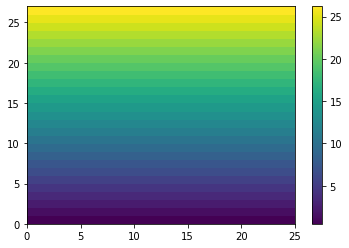

In [254]:
plt.pcolormesh(sgrid)
plt.colorbar()

In [257]:
wgrid[0,:]

array([29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684])

In [258]:
np.nanmean(ret.statistic.T, axis=0).shape

(27,)

In [260]:
def find_cumsum(x, thresh):
    pos = np.where(np.cumsum(np.sort(x)[::-1])>=thresh)
    val = (np.sort(x)[::-1])[pos[0][0]]
    #ipdb.set_trace()
    return np.where(x>=val)[0]

In [261]:
frac4_tcw = np.sum(count4.statistic.T,axis=1)/np.sum(count4.statistic)
frac4_shear = np.sum(count4.statistic.T,axis=0)/np.sum(count4.statistic)

frac_tcw = np.sum(count.statistic.T,axis=1)/np.sum(count.statistic)
frac_shear = np.sum(count.statistic.T,axis=0)/np.sum(count.statistic)

In [262]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

In [263]:
mask = np.isfinite(wgrid) & np.isfinite(ret.statistic.T)
dens = density_plot(wgrid[mask],ret.statistic.T[mask])

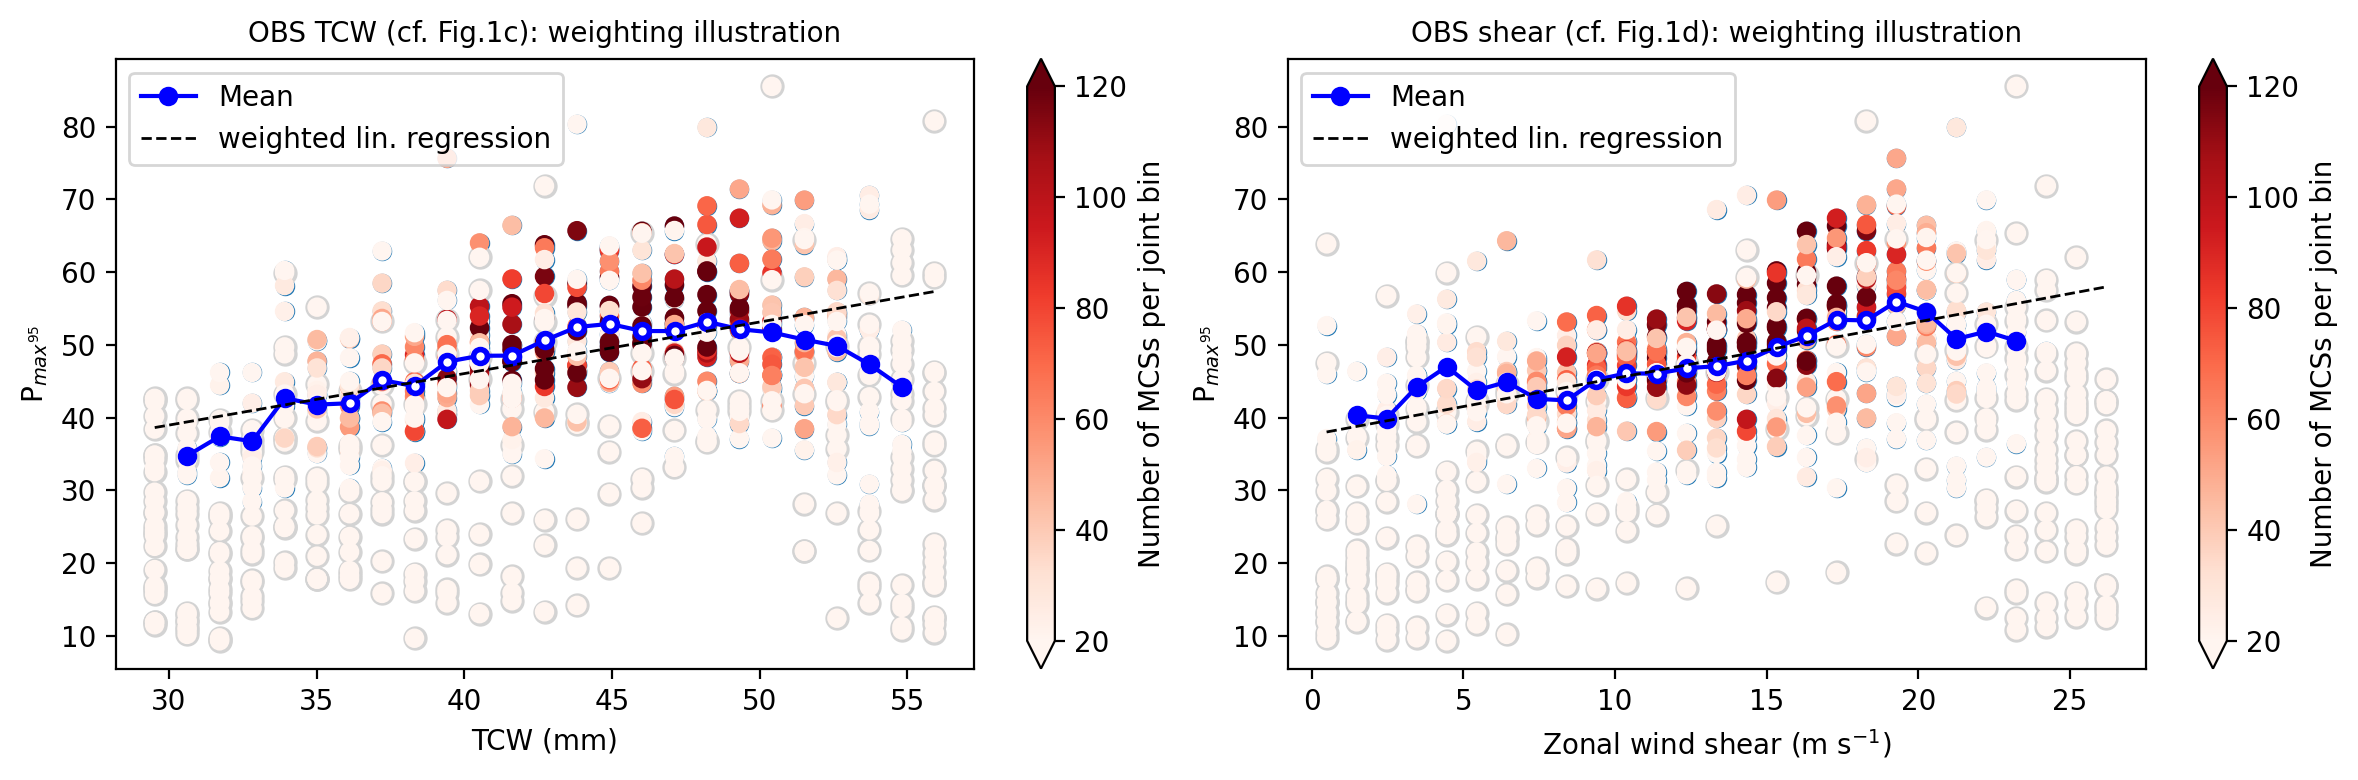

In [357]:
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(1,2,2)
plt.scatter(sgrid,gauss(ret.statistic,0.4), color='C0')
plt.scatter(sgrid[count.statistic<10],gauss(ret.statistic,0.4)[count.statistic<10], color='lightgrey', s=60)
#plt.scatter(wgrid[mask],ret.statistic.T[mask], c=dens, cmap='viridis')
mp = plt.scatter(sgrid,gauss(ret.statistic,0.4), c=count.statistic, cmap='Reds', vmin=20, vmax=120)
cbar = plt.colorbar(mp, extend='both')
cbar.set_label('Number of MCSs per joint bin')

plt.plot(sdicobs['bins'],sdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx],sdicobs['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('Zonal wind shear (m s$^{-1}$)')
plt.title('OBS shear (cf. Fig.1d): weighting illustration', fontsize=10)
plt.legend()
plt.tight_layout()
plt.legend()
ax = f.add_subplot(1,2,1)
#count.statistic.T[:, -5] = count.statistic.T[:, -5]-3
#count.statistic.T[count.statistic.T>30] = count.statistic.T[count.statistic.T>30]+10
plt.scatter(wgrid,gauss(ret.statistic.T,0.4), color='C0')
plt.scatter(wgrid[count.statistic.T<10],gauss(ret.statistic.T,0.4)[count.statistic.T<10], color='lightgrey', s=60)
#plt.scatter(wgrid[mask],ret.statistic.T[mask], c=dens, cmap='viridis')
rett = np.copy(count.statistic.T)
rett[(wgrid<42)&(count.statistic.T>25)] = rett[(wgrid<42)&(count.statistic.T>25)]+35
mp = plt.scatter(wgrid,gauss(ret.statistic.T,0.4), c=count.statistic.T, cmap='Reds', vmin=20, vmax=120)
cbar = plt.colorbar(mp, extend='both')
cbar.set_label('Number of MCSs per joint bin')

plt.plot(tdicobs['bins'],tdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('TCW (mm)')
plt.title('OBS TCW (cf. Fig.1c): weighting illustration', fontsize=10)
plt.legend()
plt.tight_layout()
# ax = f.add_subplot(1,3,3)
# plt.scatter(wgrid[count.statistic.T>25],ret.statistic.T[count.statistic.T>25], color='seagreen')
# linslope, linintercept, r_value, p_value, std_err = linregress(wgrid[count.statistic.T>25], ret.statistic.T[count.statistic.T>25])
# plt.plot(tdicobs['bins'],linslope*tdicobs['bins']+linintercept, linestyle='dashed', color='k', linewidth=1)
# plt.text(30,80, str(np.round(r_value,2))+', slope: '+str(np.round(linslope,2)))
plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_scatter_REVexample.jpg')

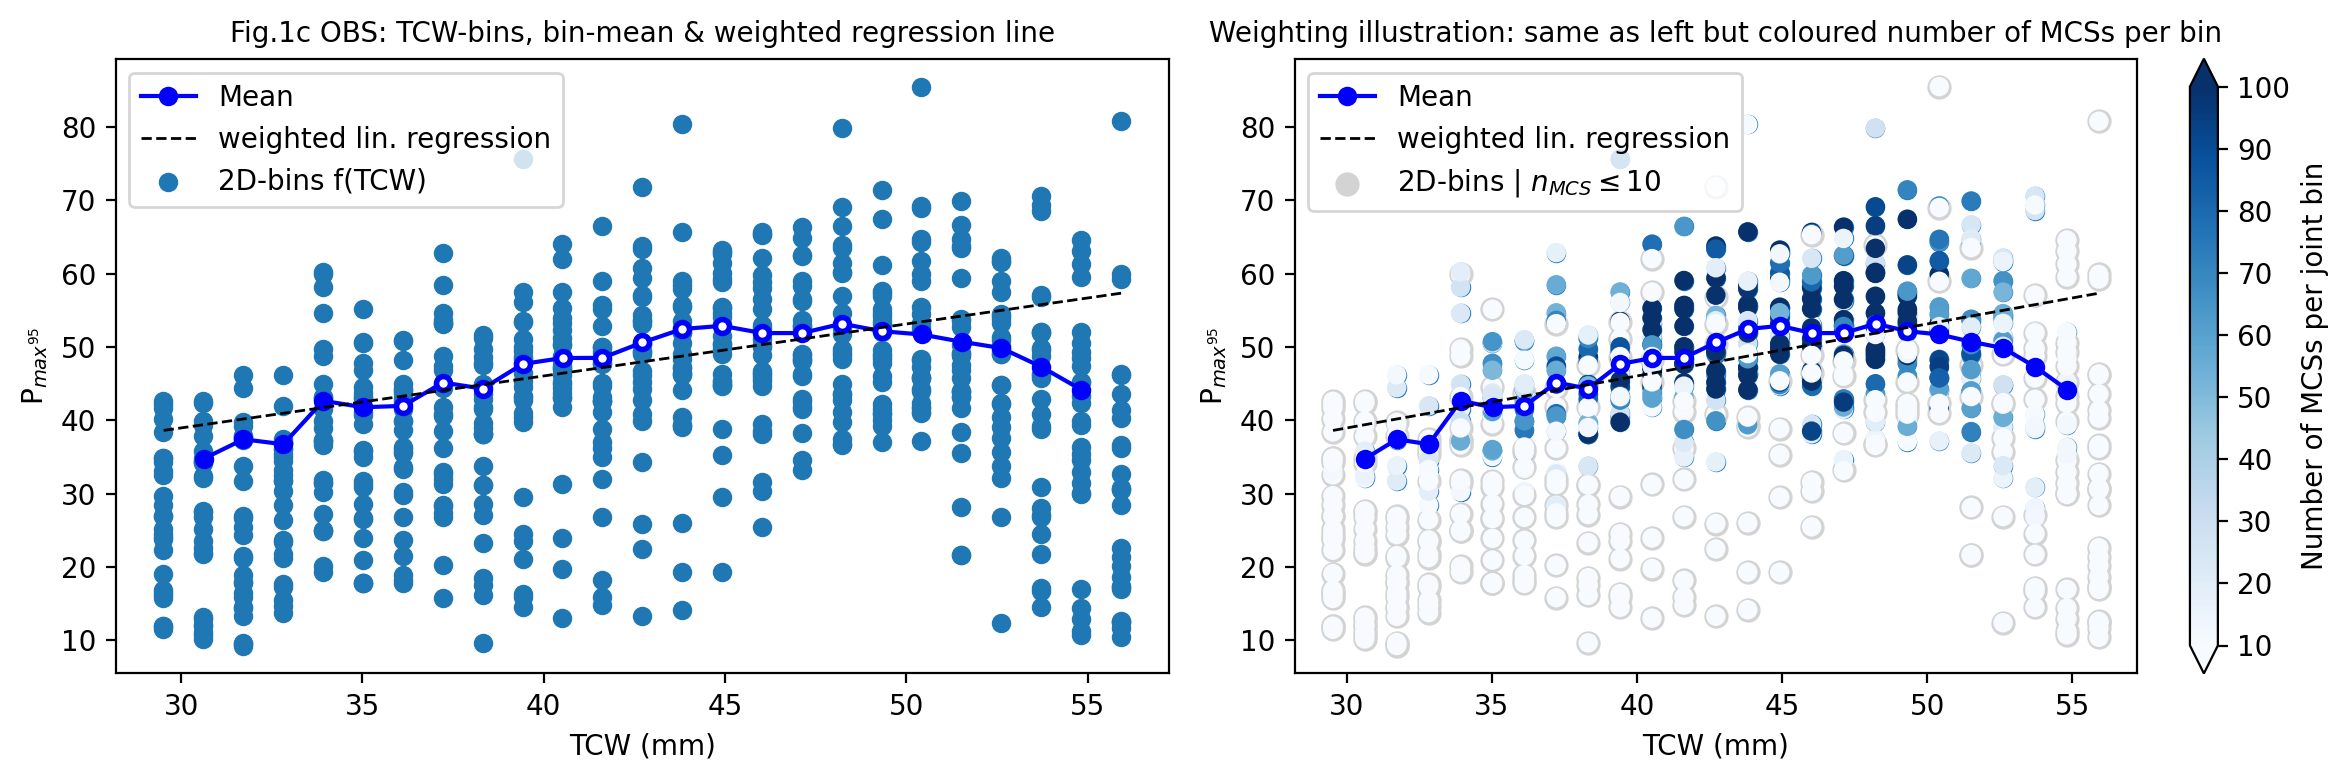

In [231]:
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(1,2,1)
plt.scatter(wgrid,gauss(ret.statistic.T,0.4), color='C0', label='2D-bins f(TCW)')
plt.plot(tdicobs['bins'],tdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('TCW (mm)')
plt.title('Fig.1c OBS: TCW-bins, bin-mean & weighted regression line', fontsize=10)
plt.legend()

# from endgame import hist2d
# outdic = hist2d.var2_binning_mean(count.statistic.T, gauss(ret.statistic.T,0.4), np.arange(0,150,5))
# #from scipy.ndimage import gaussian_filter1d
# arr = np.array(outdic['y'])
# arr[np.isnan(arr)]=49
# plt.plot(outdic['xbins'], arr, marker='o')


ax = f.add_subplot(1,2,2)
plt.scatter(wgrid,gauss(ret.statistic.T,0.4), color='C0')
plt.scatter(wgrid[count.statistic.T<10],gauss(ret.statistic.T,0.4)[count.statistic.T<10], color='lightgrey', label='2D-bins | $n_{MCS} \leq$10', s=60)
#plt.scatter(wgrid[mask],ret.statistic.T[mask], c=dens, cmap='viridis')
mp = plt.scatter(wgrid,gauss(ret.statistic.T,0.4), c=count.statistic.T, cmap='Blues', vmin=10, vmax=100)
cbar = plt.colorbar(mp, extend='both')
cbar.set_label('Number of MCSs per joint bin')

plt.plot(tdicobs['bins'],tdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('TCW (mm)')
plt.title('Weighting illustration: same as left but coloured number of MCSs per bin', fontsize=10)
plt.legend()
plt.tight_layout()
# ax = f.add_subplot(1,3,3)
# plt.scatter(wgrid[count.statistic.T>25],ret.statistic.T[count.statistic.T>25], color='seagreen')
# linslope, linintercept, r_value, p_value, std_err = linregress(wgrid[count.statistic.T>25], ret.statistic.T[count.statistic.T>25])
# plt.plot(tdicobs['bins'],linslope*tdicobs['bins']+linintercept, linestyle='dashed', color='k', linewidth=1)
# plt.text(30,80, str(np.round(r_value,2))+', slope: '+str(np.round(linslope,2)))
plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_scatter_REVexample.jpg')

In [358]:
def weighted_regress(bins,data, pval):
    import statsmodels.api as sm
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins#[pos]
    indata = data#[pos]
    inval = np.array(pval)#[pos]
    X = sm.add_constant(inbins)
    weight = inval / np.sum(inval)
    #ipdb.set_trace()
    return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight

In [359]:
mask = np.isfinite(wgrid.flat) & np.isfinite(ret.statistic.T.flat) & (count.statistic.T.flat>10)
wls_model = weighted_regress(wgrid.flat[mask], ret.statistic.T.flat[mask], count.statistic.T.flat[mask])

In [360]:
wls_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.117
Model:                            WLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     50.98
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           4.70e-12
Time:                        16:35:33   Log-Likelihood:                -1410.6
No. Observations:                 386   AIC:                             2825.
Df Residuals:                     384   BIC:                             2833.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6480      3.722      6.622      0.000      17.330      31.966
x1             0.5942      0.083      7.140      0.000       0.431       0.758
==============================================================================
Omnibus:                       47.858   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.733
Skew:                           0.886   Prob(JB):                     1.45e-14
Kurtosis:                       3.908   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

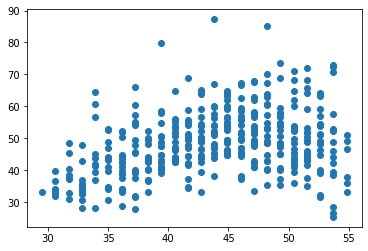

In [361]:
plt.scatter(wgrid.flat[mask],ret.statistic.T.flat[mask])

In [362]:
from utils import u_statistics as ustats

In [363]:
mask = np.isfinite(wgrid) & np.isfinite(ret.statistic.T) & np.isfinite(sgrid.T) & (count.statistic.T > 10)
r, p_e = ustats.pcor(wgrid[mask],ret.statistic.T[mask], sgrid.T[mask])
tr2 = r**2

In [364]:
r, p_e = ustats.pcor(sgrid.T[mask],ret.statistic.T[mask], wgrid[mask])
sr2 = r**2

In [365]:
print(tr2, sr2)
tr2 + sr2

0.2280329628127914 0.23873177161985568


0.4667647344326471

In [366]:
mask = np.isfinite(wgrid) & np.isfinite(ret4.statistic.T) & np.isfinite(sgrid.T) & (count4.statistic.T > 10)
r, p_e = ustats.pcor(wgrid[mask],ret4.statistic.T[mask], sgrid.T[mask])
tr2 = r**2
r, p_e = ustats.pcor(sgrid.T[mask],ret4.statistic.T[mask], wgrid[mask])
sr2 = r**2
print(tr2, sr2)
tr2 + sr2

0.5126179845617124 0.04133908099987659


0.553957065561589

In [367]:
rrs = stats.pearsonr(wgrid.flat[mask],ret.statistic.T.flat[mask])
print(rrs, rrs[0]**2)

ValueError: boolean index array should have 1 dimension

In [368]:
r, p_e = ustats.pcor(sgrid[mask],ret.statistic.T[mask], wgrid[mask])

ValueError: operands could not be broadcast together with shapes (27,25) (25,27) 

In [369]:
r**2

0.04133908099987659

In [370]:
wls_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.117
Model:                            WLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     50.98
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           4.70e-12
Time:                        16:35:35   Log-Likelihood:                -1410.6
No. Observations:                 386   AIC:                             2825.
Df Residuals:                     384   BIC:                             2833.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6480      3.722      6.622      0.000      17.330      31.966
x1             0.5942      0.083      7.140      0.000       0.431       0.758
==============================================================================
Omnibus:                       47.858   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.733
Skew:                           0.886   Prob(JB):                     1.45e-14
Kurtosis:                       3.908   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [371]:
count.statistic.T.shape

(25, 27)

In [372]:
ret.statistic.T.shape

(25, 27)

In [373]:
dicobs = run_small_2d(ret, count, testbins)
dic4 = run_small_2d(ret4, count4, testbins)

                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.488
Model:                            WLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     185.5
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           2.40e-57
Time:                        16:35:36   Log-Likelihood:                -1304.9
No. Observations:                 393   AIC:                             2616.
Df Residuals:                     390   BIC:                             2628.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3127      3.087     -0.749      0.4

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [374]:
robs = stats.pearsonr(obs['tcwv'], obs['shear'])
rc4 = stats.pearsonr(cp4['tcwv'], cp4['shear'])

In [375]:
print(robs)
print(rc4)

(-0.21985472908982942, 3.364708669553885e-245)
(-0.08046630483160121, 8.272288972065267e-70)


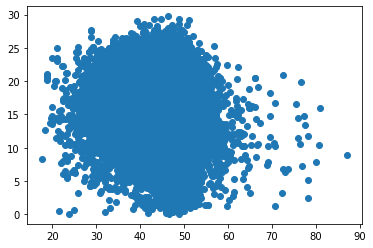

In [376]:
plt.scatter(cp4['tcwv'], cp4['shear'])

In [377]:
model.params

NameError: name 'model' is not defined

In [378]:
def func(x,y):
    return 2.3075 + 0.9421*x + 0.7397* y

In [379]:
tests = np.zeros((26,26))
for yid, y in enumerate(np.linspace(25,57,26)):
    for xid, x in enumerate(np.linspace(0,28,26)):
        tests[yid,xid] = func(x,y)

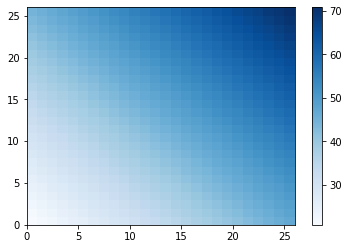

In [380]:
plt.pcolormesh(tests, cmap='Blues')
plt.colorbar()

bigpos (array([13, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17,
       17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 22]), array([18, 17, 18, 19, 17, 19, 20, 21, 22, 16, 17, 18, 19, 21, 17, 18, 19,
       20, 21, 17, 18, 19, 16, 17, 18, 19, 22, 15, 16, 19, 14]))


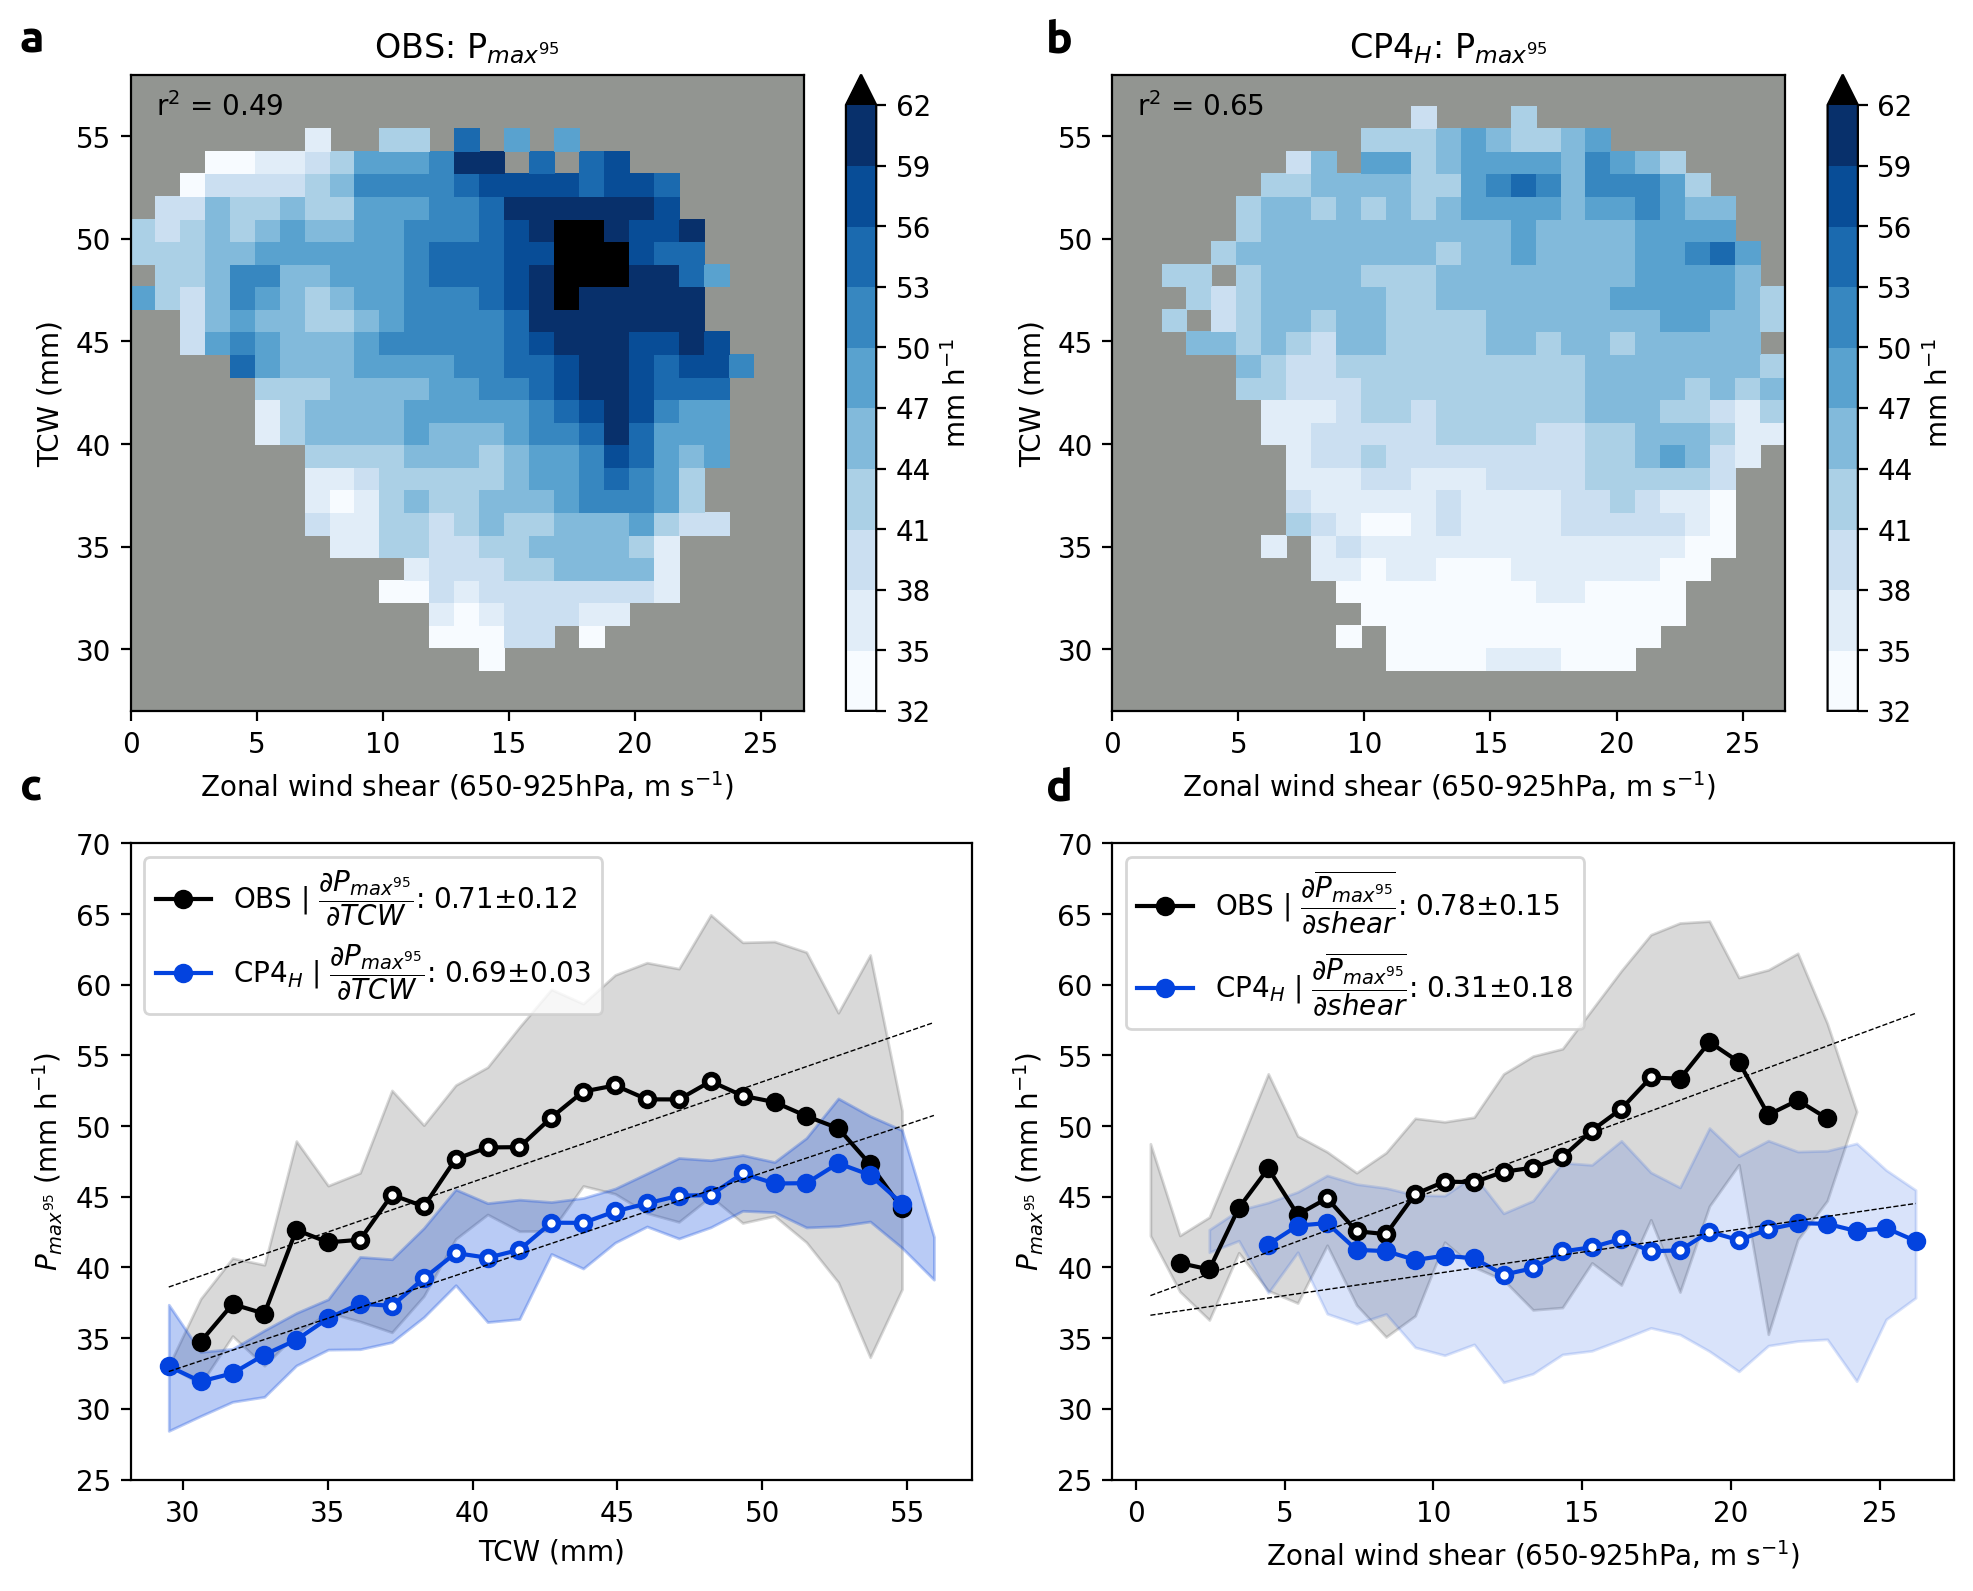

In [381]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 32
vmaxs = 62
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)

plt.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(tdic4['model'].bse[1],2)))

indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_tcw, 0.8)
plt.plot(tdic4['bins'][indx],tdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCW (mm)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(sdic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx-2],sdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_shear, 0.8)
plt.plot(sdic4['bins'][indx],sdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope'], 'SE' : sdicobs['model'].bse[1]}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[1],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(dic4['model'].bse[1],2)), fontsize=10)
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new_modelR2.jpg')

bigpos (array([13, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17,
       17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 22]), array([18, 17, 18, 19, 17, 19, 20, 21, 22, 16, 17, 18, 19, 21, 17, 18, 19,
       20, 21, 17, 18, 19, 16, 17, 18, 19, 22, 15, 16, 19, 14]))


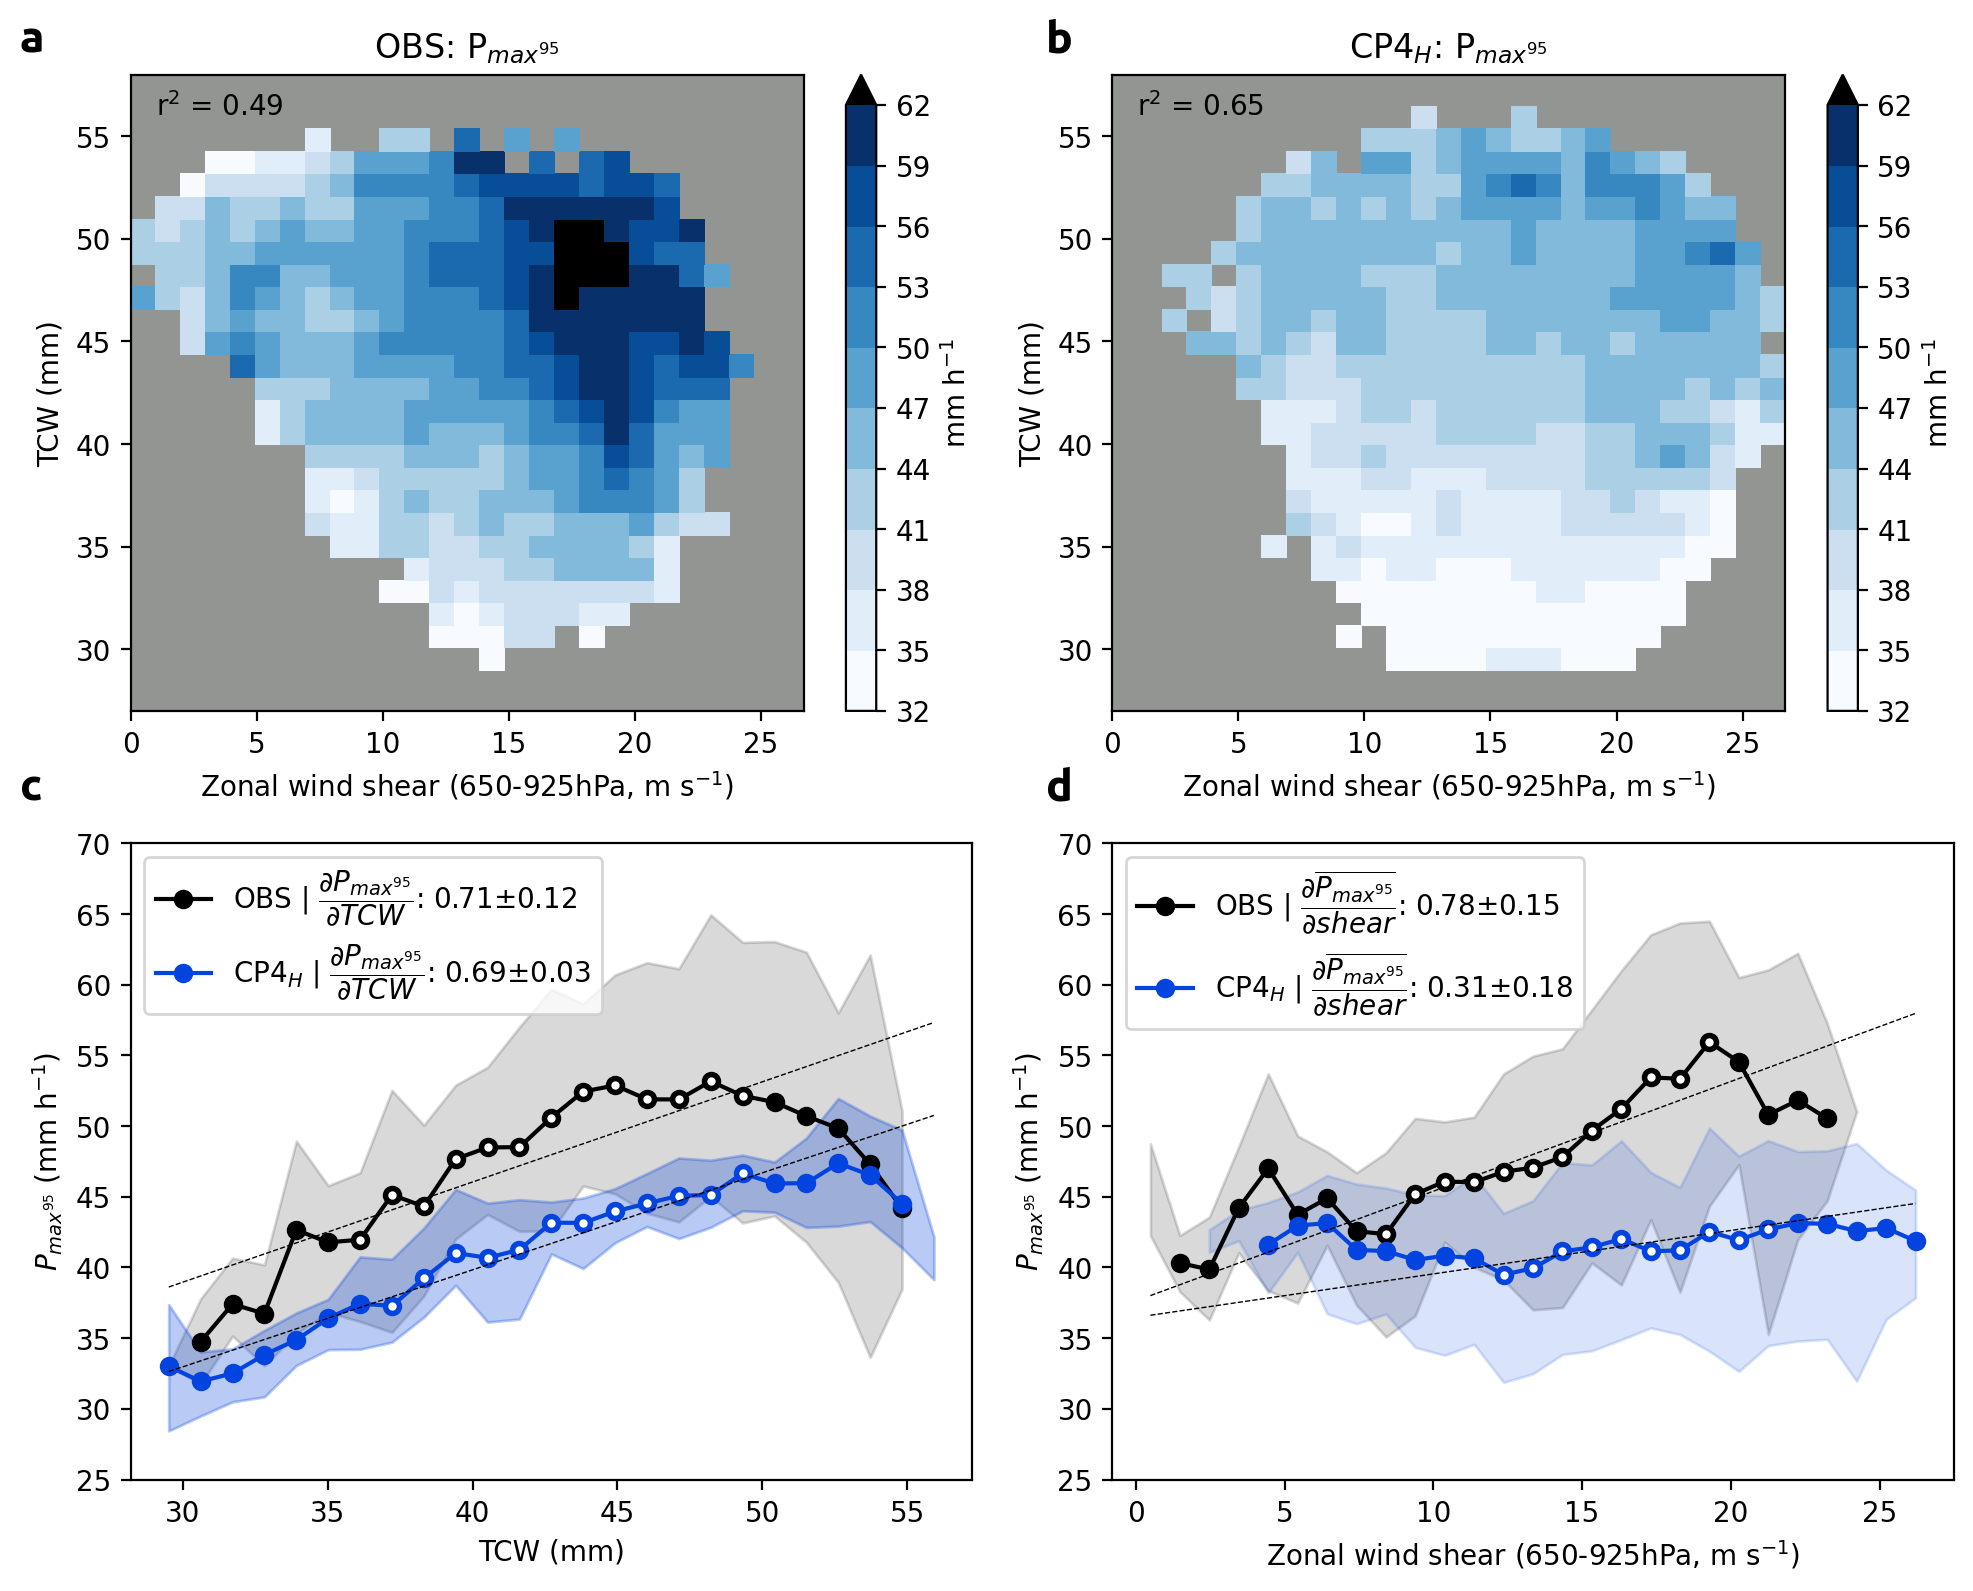

In [384]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 32
vmaxs = 62
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)

ax2.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
ax2.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
ax2.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
ax2.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(tdic4['model'].bse[1],2)))

indx = find_cumsum(frac_tcw, 0.8)
ax2.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_tcw, 0.8)
ax2.plot(tdic4['bins'][indx],tdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
ax2.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

ax2.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


ax2.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# ax22 = ax2.twinx()
# ax22.plot(tdic4['bins'], np.sum(count4.statistic.T,axis=1), color='lightblue')

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
ax2.set_xlabel('TCW (mm)')
ax2.set_ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
ax2.set_ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(sdic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx],sdicobs['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_shear, 0.8)
plt.plot(sdic4['bins'][indx],sdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope'], 'SE' : sdicobs['model'].bse[1]}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[1],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(dic4['model'].bse[1],2)), fontsize=10)
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new_modelR2.jpg')

bigpos (array([], dtype=int64), array([], dtype=int64))


Text(0, 4, 'd')

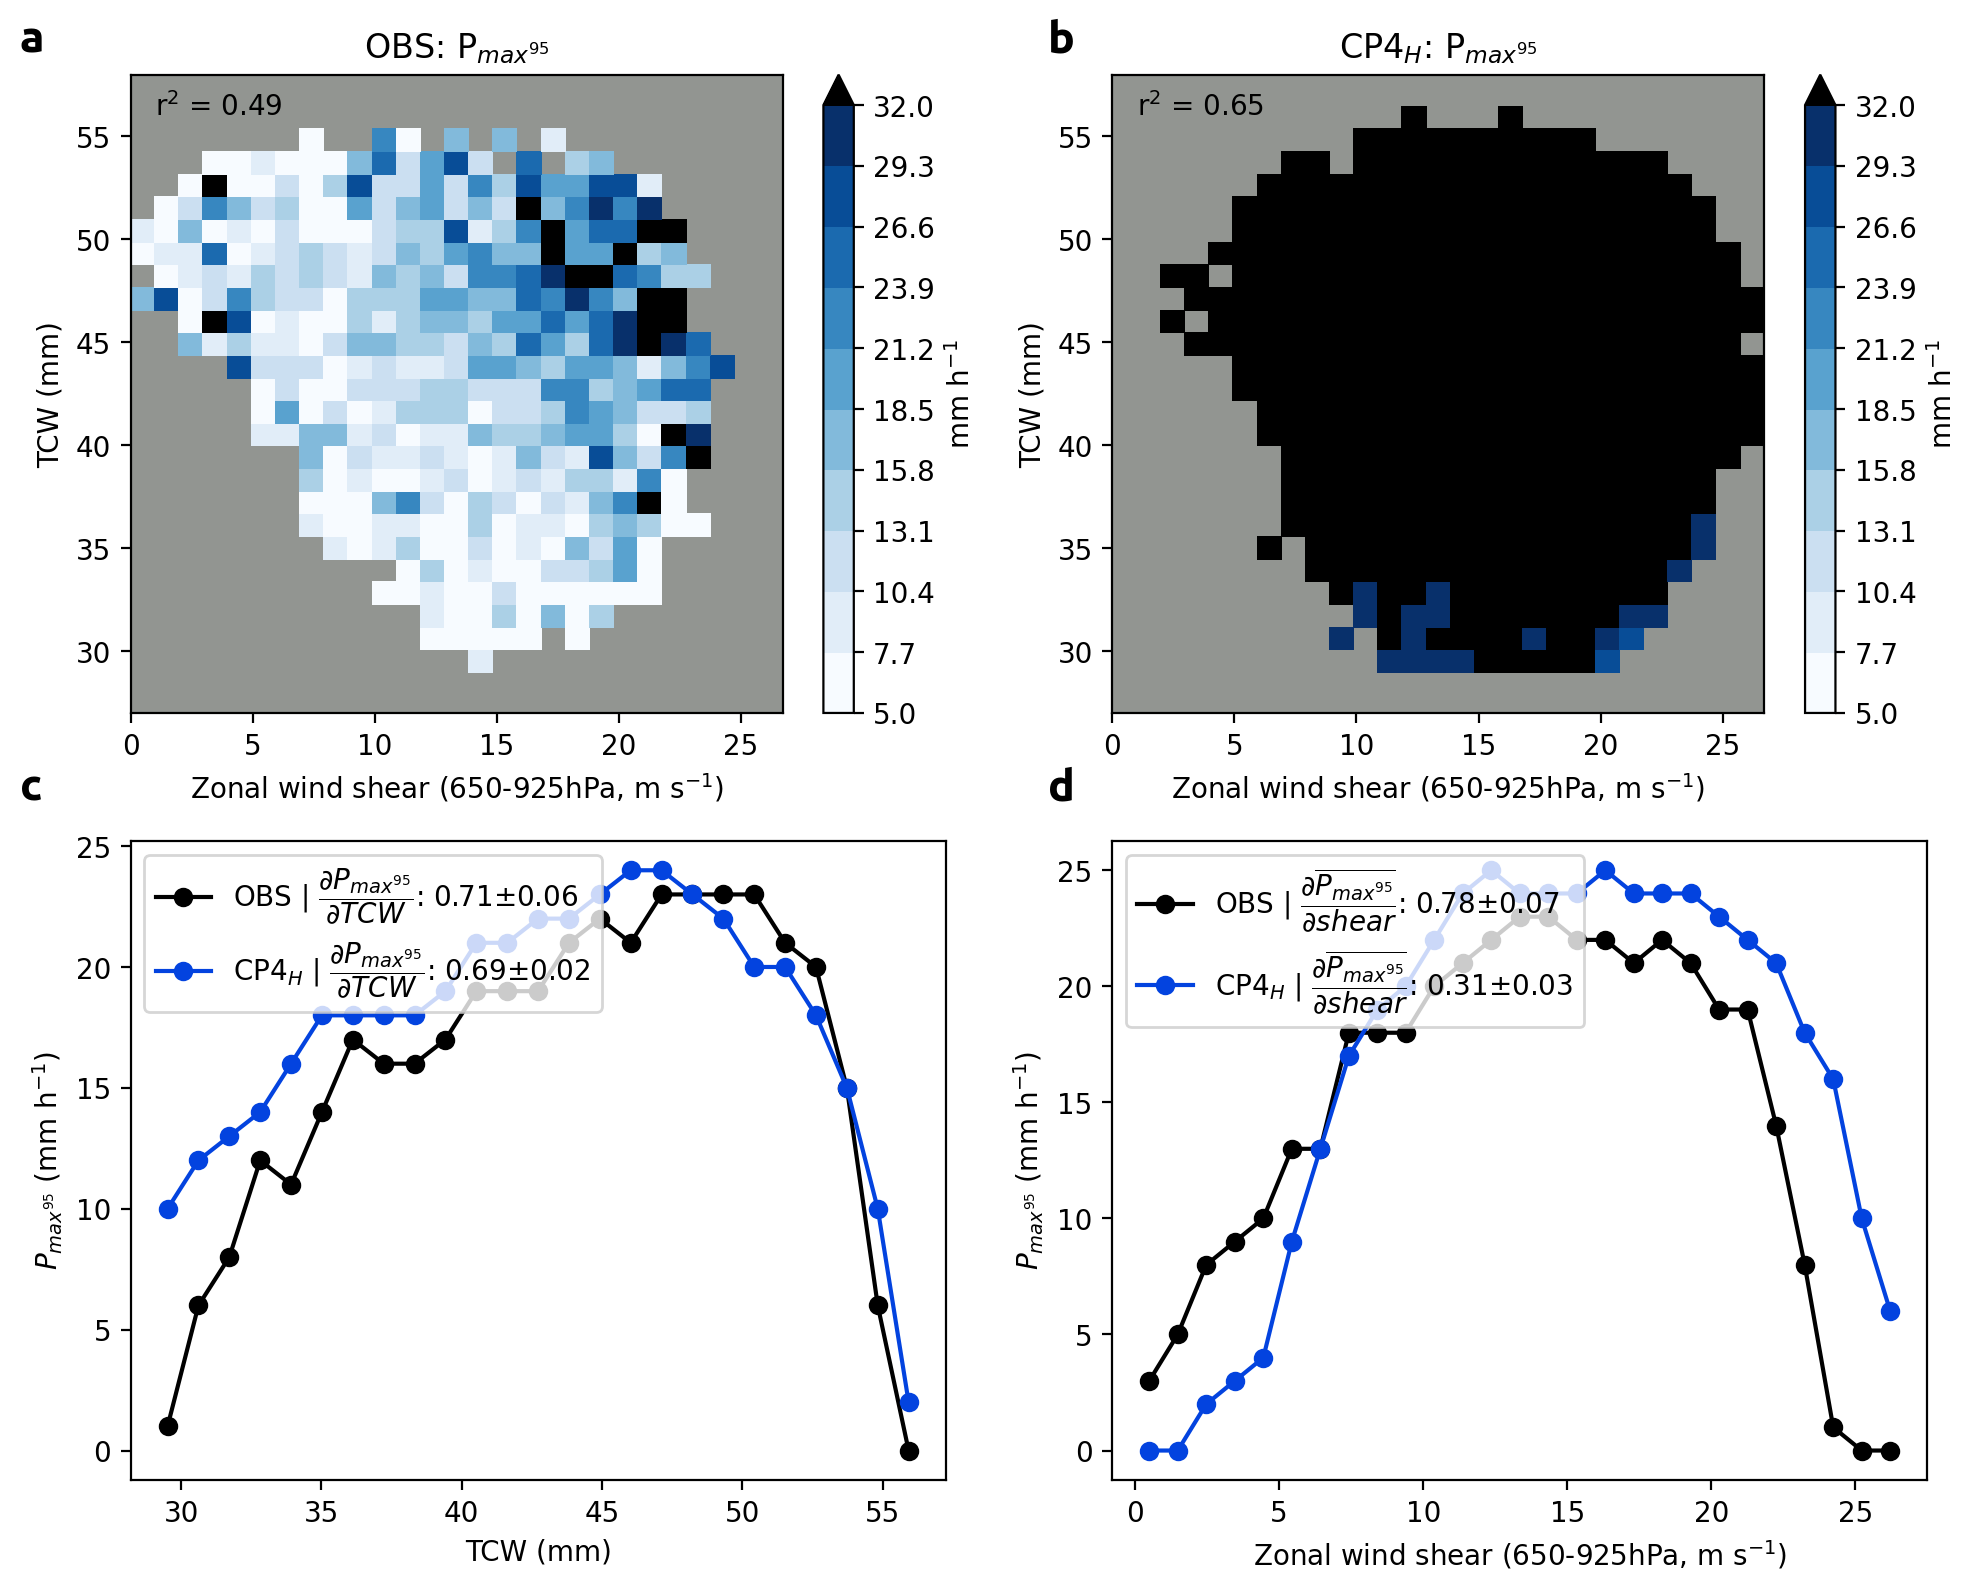

In [51]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 5
vmaxs = 32
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = thresh.statistic.T
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan


dd = dd/count.statistic.T*100
#dd = gauss(dd, 0.5)

bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)
plt.plot(tdicobs['bins'],tdicobs['valid'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(dicobs['model'].bse[2],2)))
# plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['valid'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(dic4['model'].bse[2],2)))


#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

#plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


#plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCW (mm)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
#plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['valid'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(dicobs['model'].bse[1],2)))
# plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['valid'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(dic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


#plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope']}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
#plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new.jpg')